# Classification with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from vbranch.callbacks import classification_acc
from vbranch.applications.fcn import FCN
from vbranch.applications.cnn import CNN, CNNCifar10
from vbranch.applications.resnet import ResNet18
from vbranch.applications.densenet import DenseNet3
from vbranch.losses import softmax_cross_entropy_with_logits

from vbranch.utils import TFSessionGrow, restore_sess
from vbranch.utils.training import *
from vbranch.utils.generic import get_path, save_results
from vbranch.datasets import cifar10

Using TensorFlow backend.


In [3]:
MODEL_ID = 1
ARCHITECTURE = 'densenet'
DATASET = 'cifar10'
NUM_CLASSES = 10
NUM_FEATURES = None
SAMPLES_PER_CLASS = None
BAGGING_SAMPLES = 1.0
TRAIN_FRAC = 1.

BATCH_SIZE = 128
EPOCHS = 300
# T_0 = 50
# STEPS_PER_EPOCH = 500

## Data

In [4]:
(X_train, y_train), (X_test, y_test) = get_data(DATASET, ARCHITECTURE, NUM_CLASSES,
                                NUM_FEATURES, SAMPLES_PER_CLASS, 
                                train_frac=TRAIN_FRAC, preprocess=True)
x_shape = (None,) + X_test.shape[1:]
y_shape = (None, NUM_CLASSES)

def create_generator(batch_size):
     return cifar10.DataGeneratorTrain(batch_size=batch_size,
                                       one_hot=True, preprocess=True,
                                       flip=True, padding=2,
                                       im_size=X_test.shape[1])

In [5]:
gen = create_generator(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


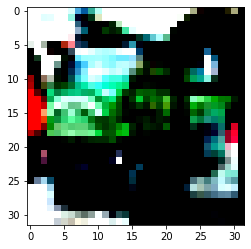

In [6]:
plt.imshow(next(gen)[0][0])

In [7]:
# X_train_aug = []

# padding = 4
# pad_spec = ((0,0), (padding, padding), (padding, padding), (0,0))
# X_train_pad = np.pad(X_train, pad_spec, 'constant', constant_values=0)
# for im in padded_batch:
#     crop_x = np.random.randint(2*self.padding)
#     crop_y = np.random.randint(2*self.padding)
#     im = im[crop_y:self.im_size+crop_y, crop_x:self.im_size+crop_x]
#     if self.flip and np.random.random() < 0.5:
#         im = np.flip(im, axis=1)
#     batch.append(im)

In [8]:
X_train.shape, y_train.shape, 
# X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 10))

In [9]:
print(X_train.min(), X_train.max(), np.mean(X_train), np.std(X_train))
# print(X_test.min(), X_test.max())

-2.4290657439446366 2.7537313432835817 -1.8789740505556917e-05 1.248454173223828


## Training

In [10]:
def path(n_branches, shared_frac):
    if shared_frac is None:
        return get_path(DATASET, ARCHITECTURE, f'sensitivity-Ba{BATCH_SIZE}')
        
    return get_path(DATASET, ARCHITECTURE, f'sensitivity-Ba{BATCH_SIZE}', vb=True, 
                    B=n_branches, S=shared_frac)

In [11]:
lr_scheduler = lr_step_scheduler((150, 0.1), (0.75*300, 0.01), (300, 0.001))

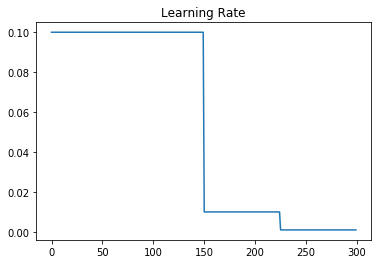

In [12]:
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
plt.plot(lr_steps)
plt.title('Learning Rate')
plt.show()

In [13]:
def build_model(n_branches, shared_frac, name='model', compile_loss=True):
#     inputs, labels, train_init_op, test_init_op = get_data_iterator(x_shape, y_shape, 
#                                                                     batch_size=BATCH_SIZE, 
#                                                                     n=n_branches, 
#                                                                     share_xy=BAGGING_SAMPLES == 0)
    
    (inputs, labels), train_init_op, test_init_op = get_data_iterator_from_generator(
        [create_generator(BATCH_SIZE // n_branches) for _ in range(n_branches)], (x_shape, y_shape), 
        n=n_branches, labels=True)
    
    print(inputs, labels)
    lr = tf.placeholder('float32', name='lr')
#     lr_scheduler = lr_exp_decay_scheduler(0.001, T_0, EPOCHS, 0.001)

    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        if ARCHITECTURE == 'densenet':
            model = DenseNet3(depth=100, growth_rate=12, 
                              inputs=inputs, classes=NUM_CLASSES, name=name, 
                              shared_frac=shared_frac) 
#                               shared_frac_blocks=[shared_frac, 1., 1., 1.])
        else:
            raise ValueError('invalid model type')

        if compile_loss:
#             optimizer = tf.train.AdamOptimizer(learning_rate=lr)
            optimizer = tf.train.MomentumOptimizer(learning_rate=lr, 
                                                   momentum=0.9, 
                                                   use_nesterov=True)
            model.compile(optimizer, softmax_cross_entropy_with_logits(weight_decay=0.0), 
                          train_init_op, test_init_op, labels=labels,
                          callbacks={'acc':classification_acc(n_branches, batch_size=250)}, 
                          schedulers={'lr:0': lr_scheduler})

    return model

In [14]:
def train(n_branches, shared_frac, model_id=1):
    dirpath = path(n_branches, shared_frac)
    model_path = os.path.join('models', dirpath, 'model_{}'.format(model_id))
    os.system('mkdir -p ' + model_path)
    print(model_path)
    
    tf.reset_default_graph()
    model = build_model(n_branches, shared_frac)
    model.summary()
    
    # Bagging
    if BAGGING_SAMPLES > 0:
        x_train_list, y_train_list = bag_samples(X_train, y_train, n_branches, 
                                                 max_samples=BAGGING_SAMPLES)
    
    train_dict = {'x:0': X_train, 'y:0': y_train, 'batch_size:0': BATCH_SIZE}
    val_dict = {'x:0': X_test, 'y:0': y_test, 'batch_size:0': 250}
    
#     if n_branches > 1 and BAGGING_SAMPLES > 0:
#         print('Bag', BAGGING_SAMPLES)
#         for i in range(n_branches):
#             train_dict[f'vb{i+1}_x:0'] = x_train_list[i]
#             train_dict[f'vb{i+1}_y:0'] = y_train_list[i]

    history = model.fit(EPOCHS, #STEPS_PER_EPOCH, 
                        create_generator(BATCH_SIZE // n_branches).get_steps_per_epoch(), 
                        train_dict=train_dict,
                        val_dict=val_dict, log_path=model_path, verbose=1)
    save_results(history, dirpath, f'train_{model_id}.csv')
    
    return history

In [15]:
# for n_branches in range(3, 5):
#     for shared_frac in [0.5, 0.75, 1.]:
#         for t in range(4):
#             train(n_branches, shared_frac, model_id=t+1)
history = train(n_branches=1, shared_frac=None, model_id=7)
# history = train(n_branches=2, shared_frac=0.0, model_id=2)

models/sensitivity-Ba128/cifar10-densenet/model_7
('float32', 'float32') ((None, 32, 32, 3), (None, 10))
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Colocations handled automatically by placer.
Tensor("input:0", shape=(?, 32, 32, 3), dtype=float32) Tensor("input:1", shape=(?, 10), dtype=float32)
Instructions for updating:
Use tf.cast instead.
i    Layer name                      Output shape      Parameters     Num param  Inbound               
-------------------------------------------------------------------------------------------------------
     Input                    

Epoch 1/300
390/390 [==============================] - 215s 550ms/step - lr:0: 0.1000 - loss: 1.2752 - acc: 0.6720 - val_loss: 0.8766 - val_acc: 0.6646
Epoch 2/300
390/390 [==============================] - 204s 524ms/step - lr:0: 0.1000 - loss: 0.7999 - acc: 0.7840 - val_loss: 0.6189 - val_acc: 0.7638
Epoch 3/300
390/390 [==============================] - 204s 523ms/step - lr:0: 0.1000 - loss: 0.6133 - acc: 0.8190 - val_loss: 0.4746 - val_acc: 0.8074
Epoch 4/300
390/390 [==============================] - 200s 513ms/step - lr:0: 0.1000 - loss: 0.5142 - acc: 0.8560 - val_loss: 0.4440 - val_acc: 0.8274
Epoch 5/300
390/390 [==============================] - 198s 508ms/step - lr:0: 0.1000 - loss: 0.4470 - acc: 0.8840 - val_loss: 0.4447 - val_acc: 0.8388
Epoch 6/300
390/390 [==============================] - 198s 508ms/step - lr:0: 0.1000 - loss: 0.3968 - acc: 0.9050 - val_loss: 0.3734 - val_acc: 0.8531
Epoch 7/300
390/390 [==============================] - 198s 508ms/step - lr:0: 0.1000 - 

390/390 [==============================] - 197s 506ms/step - lr:0: 0.1000 - loss: 0.0114 - acc: 0.9980 - val_loss: 0.3893 - val_acc: 0.9157
Epoch 108/300
390/390 [==============================] - 197s 506ms/step - lr:0: 0.1000 - loss: 0.0095 - acc: 1.0000 - val_loss: 0.4379 - val_acc: 0.9171
Epoch 109/300
390/390 [==============================] - 197s 506ms/step - lr:0: 0.1000 - loss: 0.0105 - acc: 0.9980 - val_loss: 0.3899 - val_acc: 0.9164
Epoch 110/300
390/390 [==============================] - 198s 506ms/step - lr:0: 0.1000 - loss: 0.0102 - acc: 0.9990 - val_loss: 0.3768 - val_acc: 0.9159
Epoch 111/300
390/390 [==============================] - 197s 506ms/step - lr:0: 0.1000 - loss: 0.0100 - acc: 0.9970 - val_loss: 0.4126 - val_acc: 0.9149
Epoch 112/300
390/390 [==============================] - 197s 506ms/step - lr:0: 0.1000 - loss: 0.0113 - acc: 0.9960 - val_loss: 0.3599 - val_acc: 0.9167
Epoch 113/300
390/390 [==============================] - 197s 506ms/step - lr:0: 0.1000 - 

Epoch 212/300
390/390 [==============================] - 198s 506ms/step - lr:0: 0.0100 - loss: 1.8421e-04 - acc: 1.0000 - val_loss: 0.3635 - val_acc: 0.9260
Epoch 213/300
390/390 [==============================] - 197s 506ms/step - lr:0: 0.0100 - loss: 2.4911e-04 - acc: 1.0000 - val_loss: 0.3640 - val_acc: 0.9254
Epoch 214/300
390/390 [==============================] - 197s 506ms/step - lr:0: 0.0100 - loss: 1.9516e-04 - acc: 1.0000 - val_loss: 0.3660 - val_acc: 0.9257
Epoch 215/300
390/390 [==============================] - 197s 506ms/step - lr:0: 0.0100 - loss: 2.1698e-04 - acc: 1.0000 - val_loss: 0.3659 - val_acc: 0.9259
Epoch 216/300
390/390 [==============================] - 197s 506ms/step - lr:0: 0.0100 - loss: 1.7820e-04 - acc: 1.0000 - val_loss: 0.3651 - val_acc: 0.9259
Epoch 217/300
390/390 [==============================] - 197s 506ms/step - lr:0: 0.0100 - loss: 2.3627e-04 - acc: 1.0000 - val_loss: 0.3649 - val_acc: 0.9256
Epoch 218/300
390/390 [=============================

Epoch 264/300
390/390 [==============================] - 198s 507ms/step - lr:0: 0.0010 - loss: 1.8866e-04 - acc: 1.0000 - val_loss: 0.3703 - val_acc: 0.9264
Epoch 265/300
390/390 [==============================] - 197s 506ms/step - lr:0: 0.0010 - loss: 1.3752e-04 - acc: 1.0000 - val_loss: 0.3703 - val_acc: 0.9264
Epoch 266/300
390/390 [==============================] - 197s 506ms/step - lr:0: 0.0010 - loss: 1.7933e-04 - acc: 1.0000 - val_loss: 0.3702 - val_acc: 0.9264
Epoch 267/300
390/390 [==============================] - 197s 506ms/step - lr:0: 0.0010 - loss: 1.8371e-04 - acc: 1.0000 - val_loss: 0.3701 - val_acc: 0.9264
Epoch 268/300
390/390 [==============================] - 197s 506ms/step - lr:0: 0.0010 - loss: 1.7271e-04 - acc: 1.0000 - val_loss: 0.3700 - val_acc: 0.9264
Epoch 269/300
390/390 [==============================] - 198s 506ms/step - lr:0: 0.0010 - loss: 2.1005e-04 - acc: 1.0000 - val_loss: 0.3699 - val_acc: 0.9264
Epoch 270/300
390/390 [=============================

In [ ]:
# for n_branches in range(2, 5):
#     for shared_frac in [0., 0.25, 0.5, 0.75, 0.9, 1.]:
#         for t in range(1):
#             train(n_branches, shared_frac, model_id=t+1)

models/sensitivity-Ba64/vb-cifar10-densenet/B2/S0.00/model_1
('float32', 'float32') ((None, 32, 32, 3), (None, 10))
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Colocations handled automatically by placer.
('float32', 'float32') ((None, 32, 32, 3), (None, 10))
[<tf.Tensor 'input_1:0' shape=(?, 32, 32, 3) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 32, 32, 3) dtype=float32>] [<tf.Tensor 'input_1:1' shape=(?, 10) dtype=float32>, <tf.Tensor 'input_2:1' shape=(?, 10) dtype=float32>]
Instructions for updating:
Use tf.cast instead.
i    Layer name                      Output sha

Epoch 1/100
1562/1562 [==============================] - 478s 306ms/step - lr:0: 1.0000e-03 - loss_1: 2.6070 - loss_2: 2.5999 - acc_ensemble: 0.7030 - acc_1: 0.6500 - acc_2: 0.6840 - val_loss_1: 2.0481 - val_loss_2: 1.9575 - val_acc_ensemble: 0.6919 - val_acc_1: 0.6546 - val_acc_2: 0.6727
Epoch 2/100
1562/1562 [==============================] - 451s 289ms/step - lr:0: 1.0000e-03 - loss_1: 1.7768 - loss_2: 1.7728 - acc_ensemble: 0.7880 - acc_1: 0.7590 - acc_2: 0.7610 - val_loss_1: 1.4769 - val_loss_2: 1.4928 - val_acc_ensemble: 0.7825 - val_acc_1: 0.7595 - val_acc_2: 0.7573
Epoch 3/100
1562/1562 [==============================] - 451s 289ms/step - lr:0: 1.0000e-03 - loss_1: 1.4543 - loss_2: 1.4521 - acc_ensemble: 0.8490 - acc_1: 0.8080 - acc_2: 0.8120 - val_loss_1: 1.2848 - val_loss_2: 1.2883 - val_acc_ensemble: 0.8289 - val_acc_1: 0.8004 - val_acc_2: 0.8013
Epoch 4/100
1562/1562 [==============================] - 452s 289ms/step - lr:0: 1.0000e-03 - loss_1: 1.2873 - loss_2: 1.2853 - ac

1562/1562 [==============================] - 454s 291ms/step - lr:0: 3.8019e-04 - loss_1: 0.4587 - loss_2: 0.4569 - acc_ensemble: 0.9930 - acc_1: 0.9770 - acc_2: 0.9800 - val_loss_1: 0.6855 - val_loss_2: 0.6311 - val_acc_ensemble: 0.9295 - val_acc_1: 0.9098 - val_acc_2: 0.9125
Epoch 58/100
1562/1562 [==============================] - 454s 291ms/step - lr:0: 3.3113e-04 - loss_1: 0.4454 - loss_2: 0.4401 - acc_ensemble: 0.9910 - acc_1: 0.9830 - acc_2: 0.9860 - val_loss_1: 0.6448 - val_loss_2: 0.6243 - val_acc_ensemble: 0.9336 - val_acc_1: 0.9177 - val_acc_2: 0.9121
Epoch 59/100
1562/1562 [==============================] - 454s 291ms/step - lr:0: 2.8840e-04 - loss_1: 0.4304 - loss_2: 0.4253 - acc_ensemble: 0.9930 - acc_1: 0.9810 - acc_2: 0.9870 - val_loss_1: 0.6082 - val_loss_2: 0.6184 - val_acc_ensemble: 0.9340 - val_acc_1: 0.9151 - val_acc_2: 0.9150
Epoch 60/100
1562/1562 [==============================] - 454s 291ms/step - lr:0: 2.5119e-04 - loss_1: 0.4189 - loss_2: 0.4160 - acc_ensembl

Epoch 1/100
1562/1562 [==============================] - 1100s 704ms/step - lr:0: 1.0000e-03 - loss_1: 2.3932 - loss_2: 2.4325 - acc_ensemble: 0.7160 - acc_1: 0.6930 - acc_2: 0.6770 - val_loss_1: 1.8095 - val_loss_2: 1.8308 - val_acc_ensemble: 0.7068 - val_acc_1: 0.6744 - val_acc_2: 0.6721
Epoch 2/100
1562/1562 [==============================] - 1007s 645ms/step - lr:0: 1.0000e-03 - loss_1: 1.6204 - loss_2: 1.6463 - acc_ensemble: 0.7950 - acc_1: 0.7890 - acc_2: 0.7660 - val_loss_1: 1.3225 - val_loss_2: 1.3547 - val_acc_ensemble: 0.7882 - val_acc_1: 0.7745 - val_acc_2: 0.7639
Epoch 3/100
1562/1562 [==============================] - 1007s 645ms/step - lr:0: 1.0000e-03 - loss_1: 1.3402 - loss_2: 1.3591 - acc_ensemble: 0.8490 - acc_1: 0.8300 - acc_2: 0.8150 - val_loss_1: 1.1653 - val_loss_2: 1.1874 - val_acc_ensemble: 0.8290 - val_acc_1: 0.8071 - val_acc_2: 0.7979
Epoch 4/100
1562/1562 [==============================] - 1007s 645ms/step - lr:0: 1.0000e-03 - loss_1: 1.1937 - loss_2: 1.2079 

1562/1562 [==============================] - 1012s 648ms/step - lr:0: 3.8019e-04 - loss_1: 0.4448 - loss_2: 0.4433 - acc_ensemble: 0.9880 - acc_1: 0.9810 - acc_2: 0.9760 - val_loss_1: 0.7194 - val_loss_2: 0.5696 - val_acc_ensemble: 0.9277 - val_acc_1: 0.9155 - val_acc_2: 0.9115
Epoch 58/100
1562/1562 [==============================] - 1011s 647ms/step - lr:0: 3.3113e-04 - loss_1: 0.4326 - loss_2: 0.4299 - acc_ensemble: 0.9910 - acc_1: 0.9810 - acc_2: 0.9800 - val_loss_1: 0.6569 - val_loss_2: 0.6121 - val_acc_ensemble: 0.9295 - val_acc_1: 0.9125 - val_acc_2: 0.9137
Epoch 59/100
1562/1562 [==============================] - 1012s 648ms/step - lr:0: 2.8840e-04 - loss_1: 0.4149 - loss_2: 0.4139 - acc_ensemble: 0.9920 - acc_1: 0.9790 - acc_2: 0.9770 - val_loss_1: 0.6708 - val_loss_2: 0.6246 - val_acc_ensemble: 0.9267 - val_acc_1: 0.9115 - val_acc_2: 0.9108
Epoch 60/100
1562/1562 [==============================] - 1012s 648ms/step - lr:0: 2.5119e-04 - loss_1: 0.4057 - loss_2: 0.4028 - acc_ens

Epoch 1/100
1562/1562 [==============================] - 1080s 691ms/step - lr:0: 1.0000e-03 - loss_1: 2.2823 - loss_2: 2.2756 - acc_ensemble: 0.6920 - acc_1: 0.6730 - acc_2: 0.6760 - val_loss_1: 1.6599 - val_loss_2: 1.6690 - val_acc_ensemble: 0.6959 - val_acc_1: 0.6799 - val_acc_2: 0.6730
Epoch 2/100
1562/1562 [==============================] - 985s 631ms/step - lr:0: 1.0000e-03 - loss_1: 1.5337 - loss_2: 1.5335 - acc_ensemble: 0.8010 - acc_1: 0.7790 - acc_2: 0.7740 - val_loss_1: 1.3141 - val_loss_2: 1.2159 - val_acc_ensemble: 0.7961 - val_acc_1: 0.7664 - val_acc_2: 0.7654
Epoch 3/100
1562/1562 [==============================] - 986s 631ms/step - lr:0: 1.0000e-03 - loss_1: 1.2708 - loss_2: 1.2747 - acc_ensemble: 0.8410 - acc_1: 0.8350 - acc_2: 0.8090 - val_loss_1: 1.1673 - val_loss_2: 1.1481 - val_acc_ensemble: 0.8246 - val_acc_1: 0.8033 - val_acc_2: 0.7990
Epoch 4/100
1562/1562 [==============================] - 986s 631ms/step - lr:0: 1.0000e-03 - loss_1: 1.1292 - loss_2: 1.1314 - a

1562/1562 [==============================] - 989s 633ms/step - lr:0: 3.8019e-04 - loss_1: 0.4238 - loss_2: 0.4232 - acc_ensemble: 0.9920 - acc_1: 0.9890 - acc_2: 0.9730 - val_loss_1: 0.6690 - val_loss_2: 0.6159 - val_acc_ensemble: 0.9306 - val_acc_1: 0.9176 - val_acc_2: 0.9155
Epoch 58/100
1562/1562 [==============================] - 990s 634ms/step - lr:0: 3.3113e-04 - loss_1: 0.4096 - loss_2: 0.4119 - acc_ensemble: 0.9950 - acc_1: 0.9900 - acc_2: 0.9920 - val_loss_1: 0.5955 - val_loss_2: 0.5795 - val_acc_ensemble: 0.9335 - val_acc_1: 0.9198 - val_acc_2: 0.9160
Epoch 59/100
1562/1562 [==============================] - 989s 633ms/step - lr:0: 2.8840e-04 - loss_1: 0.3940 - loss_2: 0.3983 - acc_ensemble: 0.9940 - acc_1: 0.9840 - acc_2: 0.9800 - val_loss_1: 0.6019 - val_loss_2: 0.6587 - val_acc_ensemble: 0.9338 - val_acc_1: 0.9219 - val_acc_2: 0.9173
Epoch 60/100
1562/1562 [==============================] - 989s 633ms/step - lr:0: 2.5119e-04 - loss_1: 0.3843 - loss_2: 0.3849 - acc_ensembl

Epoch 1/100
1562/1562 [==============================] - 1098s 703ms/step - lr:0: 1.0000e-03 - loss_1: 2.0218 - loss_2: 2.0236 - acc_ensemble: 0.7440 - acc_1: 0.7330 - acc_2: 0.7280 - val_loss_1: 1.4100 - val_loss_2: 1.4476 - val_acc_ensemble: 0.7274 - val_acc_1: 0.7082 - val_acc_2: 0.7156
Epoch 2/100
1562/1562 [==============================] - 1005s 643ms/step - lr:0: 1.0000e-03 - loss_1: 1.3104 - loss_2: 1.3025 - acc_ensemble: 0.8320 - acc_1: 0.8230 - acc_2: 0.8020 - val_loss_1: 1.0852 - val_loss_2: 1.1081 - val_acc_ensemble: 0.8026 - val_acc_1: 0.7954 - val_acc_2: 0.7803
Epoch 3/100
1562/1562 [==============================] - 1008s 645ms/step - lr:0: 1.0000e-03 - loss_1: 1.0488 - loss_2: 1.0568 - acc_ensemble: 0.8590 - acc_1: 0.8580 - acc_2: 0.8480 - val_loss_1: 0.9283 - val_loss_2: 0.9071 - val_acc_ensemble: 0.8411 - val_acc_1: 0.8278 - val_acc_2: 0.8311
Epoch 4/100
1562/1562 [==============================] - 1008s 645ms/step - lr:0: 1.0000e-03 - loss_1: 0.9159 - loss_2: 0.9129 

1562/1562 [==============================] - 1009s 646ms/step - lr:0: 3.8019e-04 - loss_1: 0.2109 - loss_2: 0.2096 - acc_ensemble: 0.9950 - acc_1: 0.9940 - acc_2: 0.9960 - val_loss_1: 0.5165 - val_loss_2: 0.5119 - val_acc_ensemble: 0.9149 - val_acc_1: 0.9140 - val_acc_2: 0.9135
Epoch 58/100
1562/1562 [==============================] - 1010s 646ms/step - lr:0: 3.3113e-04 - loss_1: 0.2023 - loss_2: 0.2001 - acc_ensemble: 0.9900 - acc_1: 0.9910 - acc_2: 0.9890 - val_loss_1: 0.4408 - val_loss_2: 0.4497 - val_acc_ensemble: 0.9168 - val_acc_1: 0.9172 - val_acc_2: 0.9157
Epoch 59/100
1562/1562 [==============================] - 1010s 646ms/step - lr:0: 2.8840e-04 - loss_1: 0.1907 - loss_2: 0.1914 - acc_ensemble: 0.9930 - acc_1: 0.9950 - acc_2: 0.9940 - val_loss_1: 0.4720 - val_loss_2: 0.4659 - val_acc_ensemble: 0.9208 - val_acc_1: 0.9195 - val_acc_2: 0.9220
Epoch 60/100
1562/1562 [==============================] - 1009s 646ms/step - lr:0: 2.5119e-04 - loss_1: 0.1848 - loss_2: 0.1855 - acc_ens

Epoch 1/100
1562/1562 [==============================] - 1154s 739ms/step - lr:0: 1.0000e-03 - loss_1: 1.8500 - loss_2: 1.8476 - acc_ensemble: 0.7650 - acc_1: 0.7650 - acc_2: 0.7430 - val_loss_1: 1.2625 - val_loss_2: 1.2565 - val_acc_ensemble: 0.7477 - val_acc_1: 0.7430 - val_acc_2: 0.7392
Epoch 2/100
1562/1562 [==============================] - 1061s 679ms/step - lr:0: 1.0000e-03 - loss_1: 1.1629 - loss_2: 1.1615 - acc_ensemble: 0.8100 - acc_1: 0.8160 - acc_2: 0.7990 - val_loss_1: 0.9936 - val_loss_2: 1.0031 - val_acc_ensemble: 0.8043 - val_acc_1: 0.8053 - val_acc_2: 0.7940
Epoch 3/100
1562/1562 [==============================] - 1061s 679ms/step - lr:0: 1.0000e-03 - loss_1: 0.9323 - loss_2: 0.9306 - acc_ensemble: 0.8760 - acc_1: 0.8640 - acc_2: 0.8770 - val_loss_1: 0.8590 - val_loss_2: 0.8782 - val_acc_ensemble: 0.8388 - val_acc_1: 0.8347 - val_acc_2: 0.8338
Epoch 4/100
1562/1562 [==============================] - 1061s 679ms/step - lr:0: 1.0000e-03 - loss_1: 0.8056 - loss_2: 0.8108 

## Evaluation

In [ ]:
# from vbranch.utils.generic import get_model_path, get_vb_model_path
from vbranch.utils.test import baseline_classification, compute_correlation_strength, compute_acc_from_logits
import json

In [21]:
dirpath = path(n_branches=1, shared_frac=None)
model_path = os.path.join('models', dirpath, 'model_{}'.format(6))
class_callback = classification_acc(n_branches=1, batch_size=1250)
val_dict = {'x:0': X_test, 'y:0': y_test}

with TFSessionGrow() as sess:
    restore_sess(sess, model_path)
    print(class_callback(sess, val_dict))

INFO:tensorflow:Restoring parameters from models/sensitivity-Ba64/cifar10-densenet/model_6/ckpt
{'acc': 0.9318}


### Correlation and Strength

For classification, we can compute the correlation between models and their strength. The formulas used are from the Random Forest paper:

https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf

In [ ]:
def correlation_strength(n_branches, shared_frac, model_id):
    model_path = os.path.join('models', path(n_branches, shared_frac), 
                              'model_{}'.format(model_id))
    print(model_path)

    test_init_ops = []
    tensors = []
    for i in range(n_branches):
        test_init_ops.append('test_init_op_{}'.format(i+1))
        tensors.append('model/output/vb{}/output:0'.format(i+1))

    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)
        sess.run(test_init_ops, feed_dict={'x:0':X_test, 'y:0': y_test, 
                                           'batch_size:0':len(X_test)})
        outputs = sess.run(tensors)

    return compute_correlation_strength(outputs, y_test, NUM_CLASSES, n_branches)

In [ ]:
correlation_results = {}
strength_results = {}

# num_branches = 4
shared_frac_list = [0., 0.25, 0.5, 0.75, 1.]
# shared_correlation_list = []
# shared_strength_list = []
n_trials = 4

for b in range(2, 3):
    correlation_results[b] = {}
    strength_results[b] = {}
    
    for shared in shared_frac_list:
        correlation_list = []
        strength_list = []

        for model_id in range(1, n_trials + 1):
            tf.reset_default_graph()
            c, s = correlation_strength(b, shared, model_id)
            correlation_list.append(c)
            strength_list.append(s)

        correlation_results[b][shared] = [np.mean(correlation_list), np.std(correlation_list)]
        strength_results[b][shared] = [np.mean(strength_list), np.std(strength_list)]

In [ ]:
with open(f'results/sensitivity-3/correlation-{DATASET}-{ARCHITECTURE}.json', 'w') as f:
    json.dump(correlation_results, f, indent=4)
with open(f'results/sensitivity-3/strength-{DATASET}-{ARCHITECTURE}.json', 'w') as f:
    json.dump(strength_results, f, indent=4)

In [ ]:
architecture = ['cnn'] #, 'cnnx'] #, 'fcn2', 'fcn3', 'fcn2A', 'fcn3A']
correlation = []
strength = []

for arch in architecture:
    with open(f'results/sensitivity-3/correlation-{DATASET}-{arch}.json', 'r') as f:
        correlation.append(json.load(f))
    with open(f'results/sensitivity-3/strength-{DATASET}-{arch}.json', 'r') as f:
        strength.append(json.load(f))

In [ ]:
def plot_corr_strength(n_branches):
    def mean_std(data):
        mean = []
        std = []
        for frac in shared_frac_list:
            mean.append(data[str(frac)][0])
            std.append(data[str(frac)][1])
        return np.array(mean), np.array(std)
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    for i, arch in enumerate(architecture):
        data = correlation[i][str(n_branches)]
        mean, std = mean_std(data)    
        plt.errorbar(shared_frac_list, mean, 2*std / np.sqrt(n_trials), label=arch)
        plt.legend()
        
    plt.subplot(1,2,2)
    for i, arch in enumerate(architecture):
        data = strength[i][str(n_branches)]
        mean, std = mean_std(data)    
        plt.errorbar(shared_frac_list, mean, 2*std / np.sqrt(n_trials), label=arch)    
        plt.legend()
    
    plt.show()

In [ ]:
plot_corr_strength(2)

### Model Parameters

In [ ]:
# Vbranch params
shared_frac_list = [0.] #, 0.25, 0.5, 0.75, 1.]
num_branches = 1

vbranch_params = []
for frac in shared_frac_list:
    tf.reset_default_graph()
    inputs = tf.placeholder('float32', [None, 32,32,3])
    model = build_model(num_branches, frac, compile_loss=False)
    model.summary()
    vbranch_params.append(model.count_parameters())

In [ ]:
param_ratio = [p / vbranch_params[-1] for p in vbranch_params]
ideal_ratio = num_branches - np.array(shared_frac_list)**2 * (num_branches-1)

In [ ]:
plt.scatter(shared_frac_list, param_ratio, color='orange')
# plt.plot(shared_frac_list, [1]*len(shared_frac_list))
plt.plot(shared_frac_list, ideal_ratio)

plt.xlabel('shared frac')
plt.ylabel('params / baseline')
plt.title('{} parameter count'.format(ARCHITECTURE))

plt.savefig('figs/cnn-small-parameter-count.png')
plt.show()